In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import optimize
from tqdm import tqdm
from multiprocess import Pool

from interaction import potential
from counterterm import local_LO_counterterm
from constants import MU, BETA4
from utility import log_mesh
from free_solutions import phase_shift, phase_shift_interp

plt.style.use('science')
ratio = 4/3
h = 3

Read in RG flow.

In [2]:
rgf = np.loadtxt('rgflow_local_lo_a0_fix_hp_n_14_coord_ir_corrected.txt')

In [73]:
# r0 = 4*BETA4
# r = np.linspace(3.9*BETA4, 4.1*BETA4, 100)

def wave_function(v_r, energy, r_endpts=np.array([1e-2, 2000])):
    sol = solve_ivp(
        lambda r, phi: np.array([phi[1], 2*MU*(v_r(r) - energy) * phi[0]], dtype=object),
        r_endpts, [r_endpts[0], 1], rtol=1e-9, atol=1e-12,
        dense_output=True, method='DOP853'
    )
    return sol.sol


def delta(v_r, energy, r_match=300):
    k = np.sqrt(2*MU*energy)
    sol = wave_function(v_r, energy)
    
    delta_0 = np.random.rand()
    rel_diff = 1
    
    while rel_diff > 1e-5:
        r = np.linspace(0.99*r_match, 1.01*r_match, 100)
        rho = k*r
        u, _ = sol(r)
        delta_1 = phase_shift_interp(u, rho, 0, k*r_match).real
        
        rel_diff = np.abs((delta_1 - delta_0)/delta_0)
        delta_0 = delta_1
        r_match *= 1.1
    
    return delta_1, r_match/1.1

In [74]:
ks = np.hstack(
    (np.logspace(np.log10(0.1/BETA4), np.log10(10/BETA4), 50),
     np.linspace(10.1/BETA4, 100/BETA4, 50))
)
energies = ks**2/(2*MU)

In [75]:
index = -1
R, c0 = rgf[index]
pot = lambda r: potential(r, R) + c0*local_LO_counterterm(r, R)

In [76]:
%%time
delta(pot, energies[0])

CPU times: user 169 ms, sys: 3.42 ms, total: 173 ms
Wall time: 171 ms


(-0.08605261375771658, 1139.2495007497241)

In [63]:
%%time
deltas = np.array([delta(pot, en)[0] for en in energies])

CPU times: user 40.8 s, sys: 71.6 ms, total: 40.9 s
Wall time: 40.9 s


In [64]:
ks.shape, deltas.shape

((100,), (100,))

In [65]:
deltas_mm = np.loadtxt('phase_shifts_mott_massey_wide_dense.txt')
ks_mm = deltas_mm[:, 0]
deltas_mm = deltas_mm[:, 1]

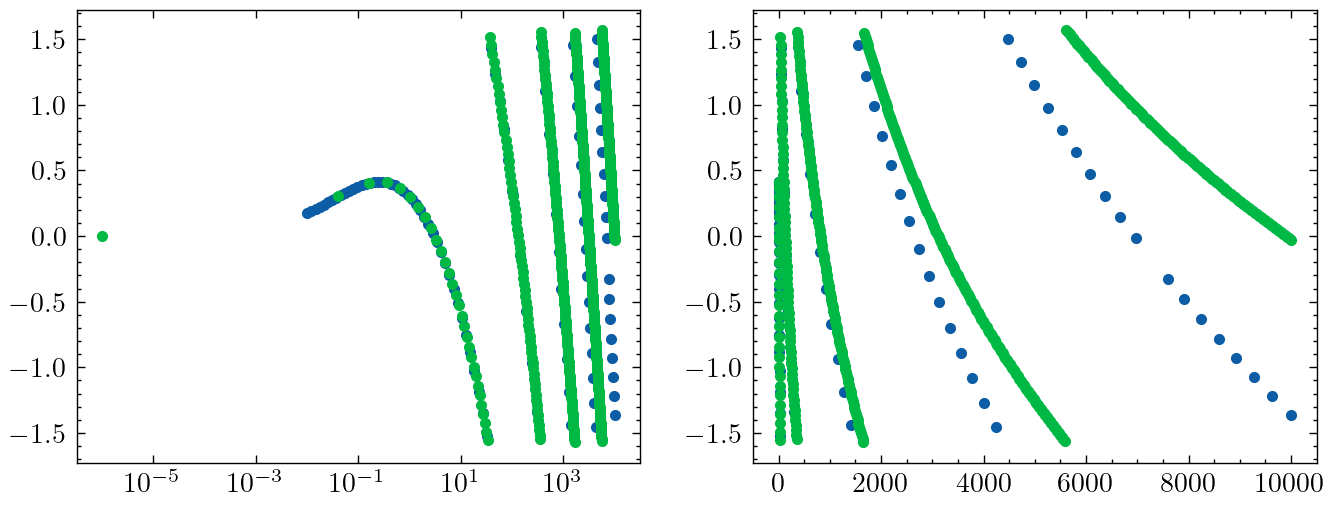

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
fig.patch.set_facecolor('white')

ax[0].scatter((ks*BETA4)**2, deltas, marker='.')
ax[0].scatter((ks_mm*BETA4)**2, deltas_mm, marker='.')
ax[1].scatter((ks*BETA4)**2, deltas, marker='.')
ax[1].scatter((ks_mm*BETA4)**2, deltas_mm, marker='.')

ax[0].set_xscale('log');

In [77]:
deltas = []

for (R, c0) in tqdm(rgf):
    pot = lambda r: potential(r, R) + c0*local_LO_counterterm(r, R)
    with Pool(4) as p:
        ds = p.map(lambda en: delta(pot, en)[0], energies)
    deltas.append(ds)

deltas = np.array(deltas)

 97%|█████████████████████████████████████████▋ | 92/95 [27:34<00:58, 19.40s/it]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_ivp/rk.py:582: RuntimeWarning: overflow encountered in multiply
  y *= x
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_ivp/rk.py:582: RuntimeWarning: overflow encountered in multiply
  y *= x
 98%|██████████████████████████████████████████ | 93/95 [27:54<00:39, 19.69s/it]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_ivp/rk.py:582: RuntimeWarning: overflow encountered in multiply
  y *= x
 99%|██████████████████████████████████████████▌| 94/95 [28:15<00:19, 19.94s/it]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_ivp/rk.py:582: RuntimeWarning: overflow encountered in multiply
  y *= x
100%|███████████████████████████████████████████| 95/95 [28:35<00:00, 18.06s/it]

In [78]:
np.savetxt('phase_shifts_lo_wide_dense_hp_n_14_coord_ir_corrected.txt', np.vstack((ks, deltas)).T)

In [83]:
bad_energies = np.where(np.isnan(deltas))[1]

In [89]:
good_deltas = np.delete(deltas, bad_energies, axis=1)
good_ks = np.delete(ks, bad_energies)

In [90]:
np.savetxt('phase_shifts_lo_wide_dense_hp_n_14_coord_ir_corrected.txt', np.vstack((good_ks, good_deltas)).T)